# **Signs Language classifier using Convolutional Neural Networks**

What will be covered in this notebook:

1. Prepare the environment
2. Exploring the Data
3. Creating Datasets and Data Loaders
4. Define the Model
5. Training the Model



## **1. Prepare the environment**

In [4]:
!pip install jovian --upgrade --quiet
# !pip install opendatasets --upgrade --quiet
!pip install -q kaggle

In [5]:
project_name = 'final-project-cnn'

In [6]:
# Prepare colab to download Kaggle Dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download the Kaggle Dataset
!kaggle datasets download -d 'datamunge/sign-language-mnist'

 73% 46.0M/62.6M [00:00<00:00, 29.5MB/s]
100% 62.6M/62.6M [00:00<00:00, 68.0MB/s]


In [8]:
# Unzip the data
!mkdir data
!unzip sign-language-mnist.zip -d data

Archive:  sign-language-mnist.zip
  inflating: data/amer_sign2.png     
  inflating: data/amer_sign3.png     
  inflating: data/american_sign_language.PNG  
  inflating: data/sign_mnist_test.csv  
  inflating: data/sign_mnist_test/sign_mnist_test.csv  
  inflating: data/sign_mnist_train.csv  
  inflating: data/sign_mnist_train/sign_mnist_train.csv  


In [9]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [10]:
# Import data required libraries
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
# Load train and validation CSV

TRAIN_CSV = 'data/sign_mnist_train.csv'
TEST_CSV = 'data/sign_mnist_test.csv'

df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

In [ ]:
# Check out the dataframes
cols_selection = ['label', 'pixel1', 'pixel2', 'pixel3', 'pixel782', 'pixel783', 'pixel784']
print('Columns are the label and 784 pixels [pixel1, ..., pixel784]:\n {}'.format(df_train.columns))
df_train[cols_selection].head(3)

Columns are the label and 784 pixels [pixel1, ..., pixel784]:
 Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


,label,pixel1,pixel2,pixel3,pixel782,pixel783,pixel784
0,3,107,118,127,204,203,202
1,6,155,157,156,103,135,149
2,2,187,188,188,195,194,195


Defining some image utility functions to be used along the notebook.

In [12]:
# Displays a batch of images in a grid
def show_batch(dl, rowSize=32, figSize=(25,20)):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=figSize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=rowSize).permute(1, 2, 0))
    break

# Displays a single image
def show_sample(img, label, reshapeSize=28):
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  print('Test label: ', label)

## **2. Exploring the Data**

This Dataset consists of xx entries, where each entry has a column with the label and 784 columns for the image pixels. That means our images have a shape of (28, 28)

Train images

We have 27455 entries.

In [ ]:
print(df_train[cols_selection].info())
df_train[cols_selection].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   label     27455 non-null  int64
 1   pixel1    27455 non-null  int64
 2   pixel2    27455 non-null  int64
 3   pixel3    27455 non-null  int64
 4   pixel782  27455 non-null  int64
 5   pixel783  27455 non-null  int64
 6   pixel784  27455 non-null  int64
dtypes: int64(7)
memory usage: 1.5 MB
None


,label,pixel1,pixel2,pixel3,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


### Analyzing our labels and images

The letters are 25, from 'a' to 'z', corresponding to the American Sign Language.

> *In this this dataset we got only 24 labels, skipping examples for letter 'J', which is label 9 and letter 'Z', which would be label 25. This is because these letters have gesture motions and cannot be represented with static images*



In [13]:
# Getting our labels
labels = df_train['label'].unique()
print('We have {} labels, from {} to {}, skipping label 9'.format(len(labels), np.min(labels), np.max(labels)))
print(np.sort(labels))
num_classes = len(labels)

We have 24 labels, from 0 to 24, skipping label 9
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [14]:
# Let's also put the textual labels in a dictionary for later use:
classes_labels = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J', # There are no examples for label 9
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y'
}

In [ ]:
# Here we can see we have no labels for 'J' which would correspond to label 9
sign9 = df_train.loc[df_train['label'] == 9]
print(len(sign9))

0


Label:  [8]


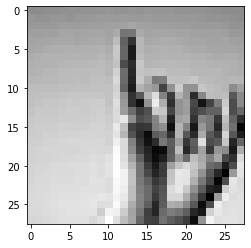

In [ ]:
sign8 = df_train.loc[df_train['label'] == 8]
# Getting only the first example
sign8_sample = sign8.head(1)
sign_label = sign8_sample['label']
sign_image = sign8_sample.drop(columns='label')
# Some reshape
sign_image = sign_image.values.reshape(28, 28)
# Displaying a sample of letter 'I'
show_sample(sign_image, sign_label.values)

From letter 'I' it jumps to letter 'K'

Label:  [10]


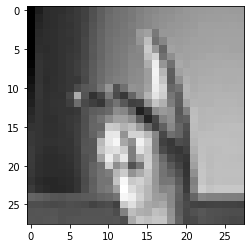

In [ ]:
sign10 = df_train.loc[df_train['label'] == 10]
# Getting only the first example
sign10_sample = sign10.head(1)
sign_label = sign10_sample['label']
sign_image = sign10_sample.drop(columns='label')
# Some reshape
sign_image = sign_image.values.reshape(28, 28)
# Displaying a sample of letter 'I'
show_sample(sign_image, sign_label.values)

Test images

We have 7172 entries and as we can see on the description table, there are also 24 labels.

In [ ]:
print(df_test[cols_selection].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   label     7172 non-null   int64
 1   pixel1    7172 non-null   int64
 2   pixel2    7172 non-null   int64
 3   pixel3    7172 non-null   int64
 4   pixel782  7172 non-null   int64
 5   pixel783  7172 non-null   int64
 6   pixel784  7172 non-null   int64
dtypes: int64(7)
memory usage: 392.3 KB
None


In [ ]:
y_train = df_train['label']
y_test = df_test['label']

To know if we have the same amount of train images for every label, let's plot it. If the difference is big, we would need to normalize the dataset.

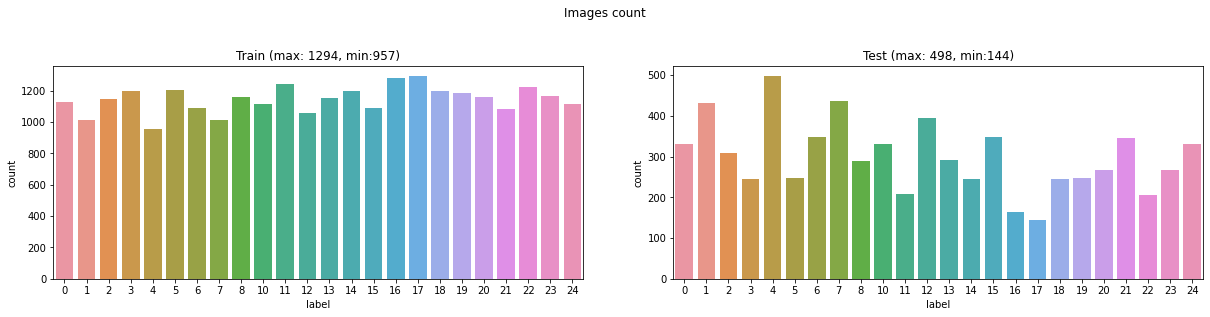

In [ ]:
max_train_samples = df_train.groupby('label')['pixel1'].count().max()
min_train_samples = df_train.groupby('label')['pixel1'].count().min()
max_test_samples = df_test.groupby('label')['pixel1'].count().max()
min_test_samples = df_test.groupby('label')['pixel1'].count().min()

fig, (plt1, plt2) = plt.subplots(1, 2, figsize = (18,5))
fig.suptitle('Images count')

sns.countplot(ax=plt1, x=y_train);
plt1.set_title('Train (max: {}, min:{})'.format(max_train_samples, min_train_samples))

sns.countplot(ax=plt2, x=y_test);
plt2.set_title('Test (max: {}, min:{})'.format(max_test_samples, min_test_samples))

plt.tight_layout(pad=5, w_pad=5)

The training data seems to be balanced, meaning for each training label there are enough examples. Validation data seems to be a bit more unbalanced, but this is not really a big deal for validation phase.

## **3. Creating Datasets and Data Loaders**



### Custom dataset

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [16]:
class HandSignsDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.df = pd.read_csv(csv_file)
    self.transform = transform
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.loc[idx]
    img, img_label = row[map(lambda x :x not in ['label'], list(self.df.columns))], row['label']

    img = img.astype(np.uint8)
    img = np.array([img])

    # Reshape to 28 x 28
    img = img.reshape(28, 28, -1)

    if self.transform:
      img = self.transform(img)
    return img, img_label

### Preview of images

We'll apply some transformations to data in order to improve the training and avoid overfitting. For this reason, I'll display a batch of images first and another after transformations.

Images without transformations

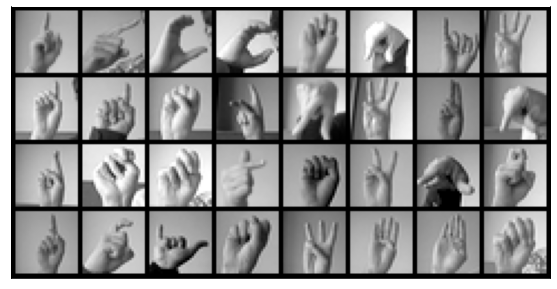

In [ ]:
sampleDataset = HandSignsDataset(TRAIN_CSV, transforms.Compose([transforms.ToTensor()]))
sample_dl = DataLoader(sampleDataset, 32, num_workers=1, pin_memory=True)
show_batch(sample_dl, 8, (15, 5))

### Data augmentation

We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 28 x 28 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

Since we have nparrays on the range [0, 255] and torchvision transformations accept only `PIL Images` as input, the first transformation to be applied will be `transform.ToPILImage()`

In [18]:
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(28, padding=4, padding_mode='reflect'),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

# Transformations are applied only to train dataset, to validate we need the original images.
valid_transforms = transforms.Compose([transforms.ToTensor()])

In [ ]:
sampleTransformedDataset = HandSignsDataset(TRAIN_CSV, transform=train_transforms)

Images after transformations were applied

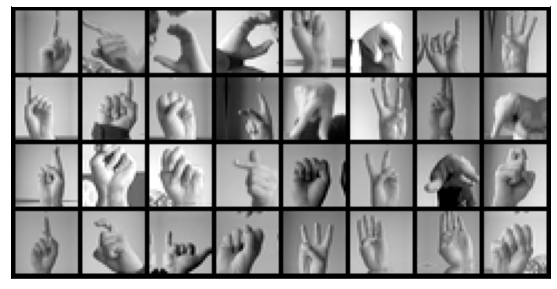

In [ ]:
sampleTrans_dl = DataLoader(sampleTransformedDataset, 32, num_workers=1, pin_memory=True)
show_batch(sampleTrans_dl, 8, (15, 5))

### Training & Validation sets

One good strategy is to determine a good set of hyperparameters and then retrain on a smaller validation set, normally a validation percentage of 10% is used.

On previous models it was a good practice to split the data into training and validation datasets using the strategy mentioned above. Now we'll use a more robust model where also transformations have been added to the test images, so this give us enough data for the training already. That's why we'll use the test data as our validation set. 

Maybe on later versions the strategy to split the dataset can be used to tune and improve the accuracy.


In [19]:
train_ds = HandSignsDataset(TRAIN_CSV, transform=train_transforms)
valid_ds = HandSignsDataset(TEST_CSV, transform=valid_transforms)

### Data Loaders

Once we have the `train_ds` and `valid_ds`, we can create data loaders for retrieving images in batches. 
We'll use a relatively large batch size of 128 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

`shuffle=True` is only required for the training data loader, since it helps to improve the training, is not really needed for the validation.

In [20]:
batch_size = 128

In [21]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
len(train_dl), len(valid_dl)

(215, 29)

## **4. Define the Model**

One change we can add to a CNN model is the addition of a residual block, which adds the original input back to the output feature map obtained by passing the input one or more convolutional layers.
This is called a ResNet or Residual blocks.

<div style='display: flex' align='center'>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/59/Resnet.png"/>
</div>

We'll use an arquitecture with some convolution layers. 
Why convolution layers? because of their ability to capture local information and reduce the number of parameters with weight sharing, 
almost all vision-based models (and a few NLP-models) use convolutions of one form or the other.

**Example of a Simple Residual Block**

In [22]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    # We'll apply 2 convolutional layers, without modifying the tensor shape,
    # because we'll add the 'x' identity to the output of the second ReLU layer.
    self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    # Adding the 'x' input, for this operation both tensor shapes should be compatible.
    out = self.relu2(out) + x
    return out

**ResNet9 Architecture**

Now that the ``` SimpleResidualBlock ``` class has been defined and is working properly, it's possible to think about a more robust model, where we can pile several residual blocks.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)



In [27]:
# Helper function to calculate the accuracy
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class HandSignsClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  # Logging functions validation_epoch_end and epoch_end.
  # it's important to track the accuracy and loss for each epoch.
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

As we see on the architecture graphic, we also have convolution blocks. Here we'll define this blocks and the whole ResNet9 model

In [28]:
# Convolution block
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

# ResNet9 Model
class ResNet9(HandSignsClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1  = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2  = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(3), #4 , out (3, 3)
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
  def forward(self, xb):
    # --------- Prep ----------
    out = self.conv1(xb) # ( 1 )
    # -------------------------

    # ------- Layer 1 ---------
    resOut1 = self.conv2(out) # ( 2 )
    out = self.res1(resOut1) + resOut1 # ( 3, 4 )
    # -------------------------

    # ------- Layer 2 ---------
    out = self.conv3(out) # ( 5 )
    # -------------------------

    # ------- Layer 3 ---------
    resOut2 = self.conv4(out) # ( 6 )
    out = self.res2(resOut2) + resOut2 # ( 7, 8 )
    # -------------------------

    # ------ Classifier -------
    out = self.classifier(out) # ( 9 )
    # -------------------------

    return out

### Using a GPU

Here I'll define a couple of helper functions and a helper class to move our model & data to the GPU. This will improve our training time considerely.

To use a GPU, we define a couple of helper functions (`
get_default_device` and `to_device`) as well as a helper class `DeviceDataLoader` to move the model & data to GPU as required.

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

Moving model and data loaders to GPU

In [26]:
# Data loaders
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model
model = to_device(ResNet9(1, num_classes + 1), device)

In [ ]:
# Testing the model
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 25])
out[0]: tensor([-0.4201, -1.6182, -1.6038,  1.7286,  2.4099,  1.8298, -2.2566, -0.8477,
         2.3302, -1.5052, -0.2372,  1.2969,  0.1482, -1.1375,  0.2694,  1.8261,
         0.1781, -0.9519,  2.1320, -0.4234, -3.2407, -2.1837, -1.8044, -1.3281,
         0.2385], device='cuda:0', grad_fn=<SelectBackward>)


## **5. Training the model**

Before I start training the model, there still one improvement I'd like to add.

I always had the question of how to set the learning rate or which was the best number. Till I've learned about the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, than gradually decreasing it to a very low value for the remaining epochs.

Another tecniques to be used are: Weight decay and Gradient clipping.

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  # Set up one-cycle learning rate scheduler
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()

      # Record & update learning rate
      lrs.append(get_lr(optimizer))
      scheduler.step()
    
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.022090516984462738, 'val_loss': 3.2158782482147217}]

Now everything is set to start to train the model, instead of using SGD, Adam optimizer will be used because implements techniques like momentum and adaptive learning rates for faster training.

In [ ]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00759, train_loss: 0.8809, val_loss: 1.4363, val_acc: 0.6659
Epoch [1], last_lr: 0.00950, train_loss: 0.1475, val_loss: 2.5507, val_acc: 0.4355
Epoch [2], last_lr: 0.00611, train_loss: 0.0293, val_loss: 0.0761, val_acc: 0.9758
Epoch [3], last_lr: 0.00188, train_loss: 0.0025, val_loss: 0.0007, val_acc: 1.0000
Epoch [4], last_lr: 0.00000, train_loss: 0.0005, val_loss: 0.0003, val_acc: 1.0000
CPU times: user 22.8 s, sys: 2.23 s, total: 25 s
Wall time: 2min 28s


In [ ]:
train_time = '2min 28s'

Let's plot the metrics to see how the trainig behaved

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

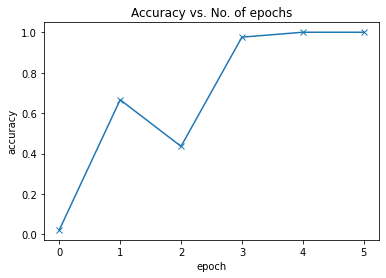

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

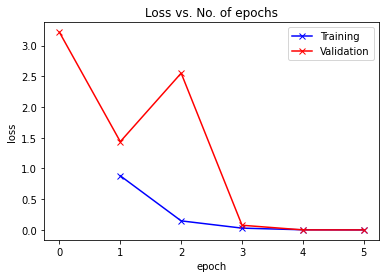

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

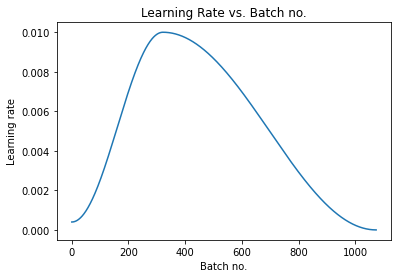

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.

## Testing with individual images

In [33]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

Test label:  6
Label: G , Predicted label: 6


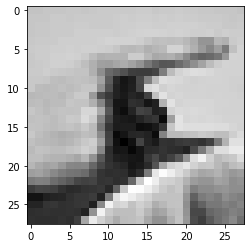

In [ ]:
img, label = valid_ds[0]
show_sample(img[0], label)
print('Label:', classes_labels[label], ', Predicted label:', predict_image(img, model))

Test label:  12
Label: M , Predicted label: 12


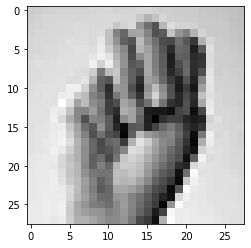

In [ ]:
img, label = valid_ds[13]
show_sample(img[0], label)
print('Label:', classes_labels[label], ', Predicted label:', predict_image(img, model))

Test label:  15
Label: P , Predicted label: 15


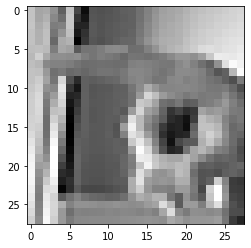

In [ ]:
img, label = valid_ds[40]
show_sample(img[0], label)
print('Label:', classes_labels[label], ', Predicted label:', predict_image(img, model))

Test label:  8
Label: I , Predicted label: 8


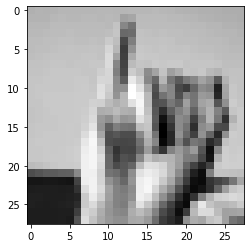

In [ ]:
img, label = valid_ds[100]
show_sample(img[0], label)
print('Label:', classes_labels[label], ', Predicted label:', predict_image(img, model))

Test label:  18
Label: S , Predicted label: 18


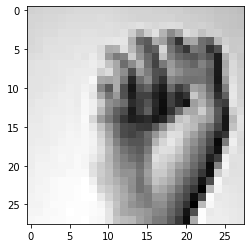

In [ ]:
img, label = valid_ds[4504]
show_sample(img[0], label)
print('Label:', classes_labels[label], ', Predicted label:', predict_image(img, model))

## Loading a model

This code in this section is meant to be executed only of the Model has been previously trained and we don't want to traing it again. We'll just load the weights and bias matrices mapped to the right attributes to a new model.

In [29]:
loaded_model = to_device(ResNet9(1, num_classes + 1), device)

In [30]:
loaded_model.load_state_dict(torch.load('hand-gestures-classifier.pth'))

<All keys matched successfully>

Now the loaded_model is ready to make predictions, so here is possible to evaluate on the test dataset.

In [44]:
evaluate(loaded_model, valid_dl)

{'val_acc': 1.0, 'val_loss': 0.0003249419678468257}

## Save and Commit

Saving the model, in case we want to continue the training and not start from scratch.

In [ ]:
torch.save(model.state_dict(), 'hand-gestures-classifier.pth')

It's important to log as well all the hyperparams.

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


To log the metrics helps to perform a better training, knowing the improvements.

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, outputs=['hand-gestures-classifier.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/hada-garcia/final-project-cnn


'https://jovian.ai/hada-garcia/final-project-cnn'

### References

1.   Kaggle: https://www.kaggle.com/datamunge/sign-language-mnist/notebooks
2.   Custom Datasets: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
3. ResNet blocks. [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
4. One Cycle Learning Rate Policy. [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

